<a href="https://colab.research.google.com/github/krithika162003/Food-Calorie-Analytics/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install inference_sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image



# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import supervision as sv

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import zipfile
import pandas as pd

# Specify the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/archive.zip"
# Specify the directory where you want to extract the contents
extracted_dir_path = "D:\downloads\food_extracted"

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Generate data paths with labels
filepaths = []
labels = []

# Iterate through the extracted directories
for root, dirs, files in os.walk(extracted_dir_path):
    for f in files:
        # Get the full file path
        fpath = os.path.join(root, f)
        filepaths.append(fpath)

        # Determine the label based on the parent directory name
        label = os.path.basename(root)
        labels.append(label)

# Concatenate data paths with labels into one DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Optionally, you can clean up the extracted directory after you're done processing
# Note: Be cautious with this step, as it deletes the extracted files
# import shutil
# shutil.rmtree(extracted_dir_path)


In [ ]:
# Splitting the original DataFrame into training and dummy sets without stratification
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# Splitting the dummy DataFrame into validation and test sets without stratification
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)

In [ ]:
# crobed image size
batch_size =64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4663 validated image filenames belonging to 20 classes.
Found 584 validated image filenames belonging to 20 classes.
Found 584 validated image filenames belonging to 20 classes.


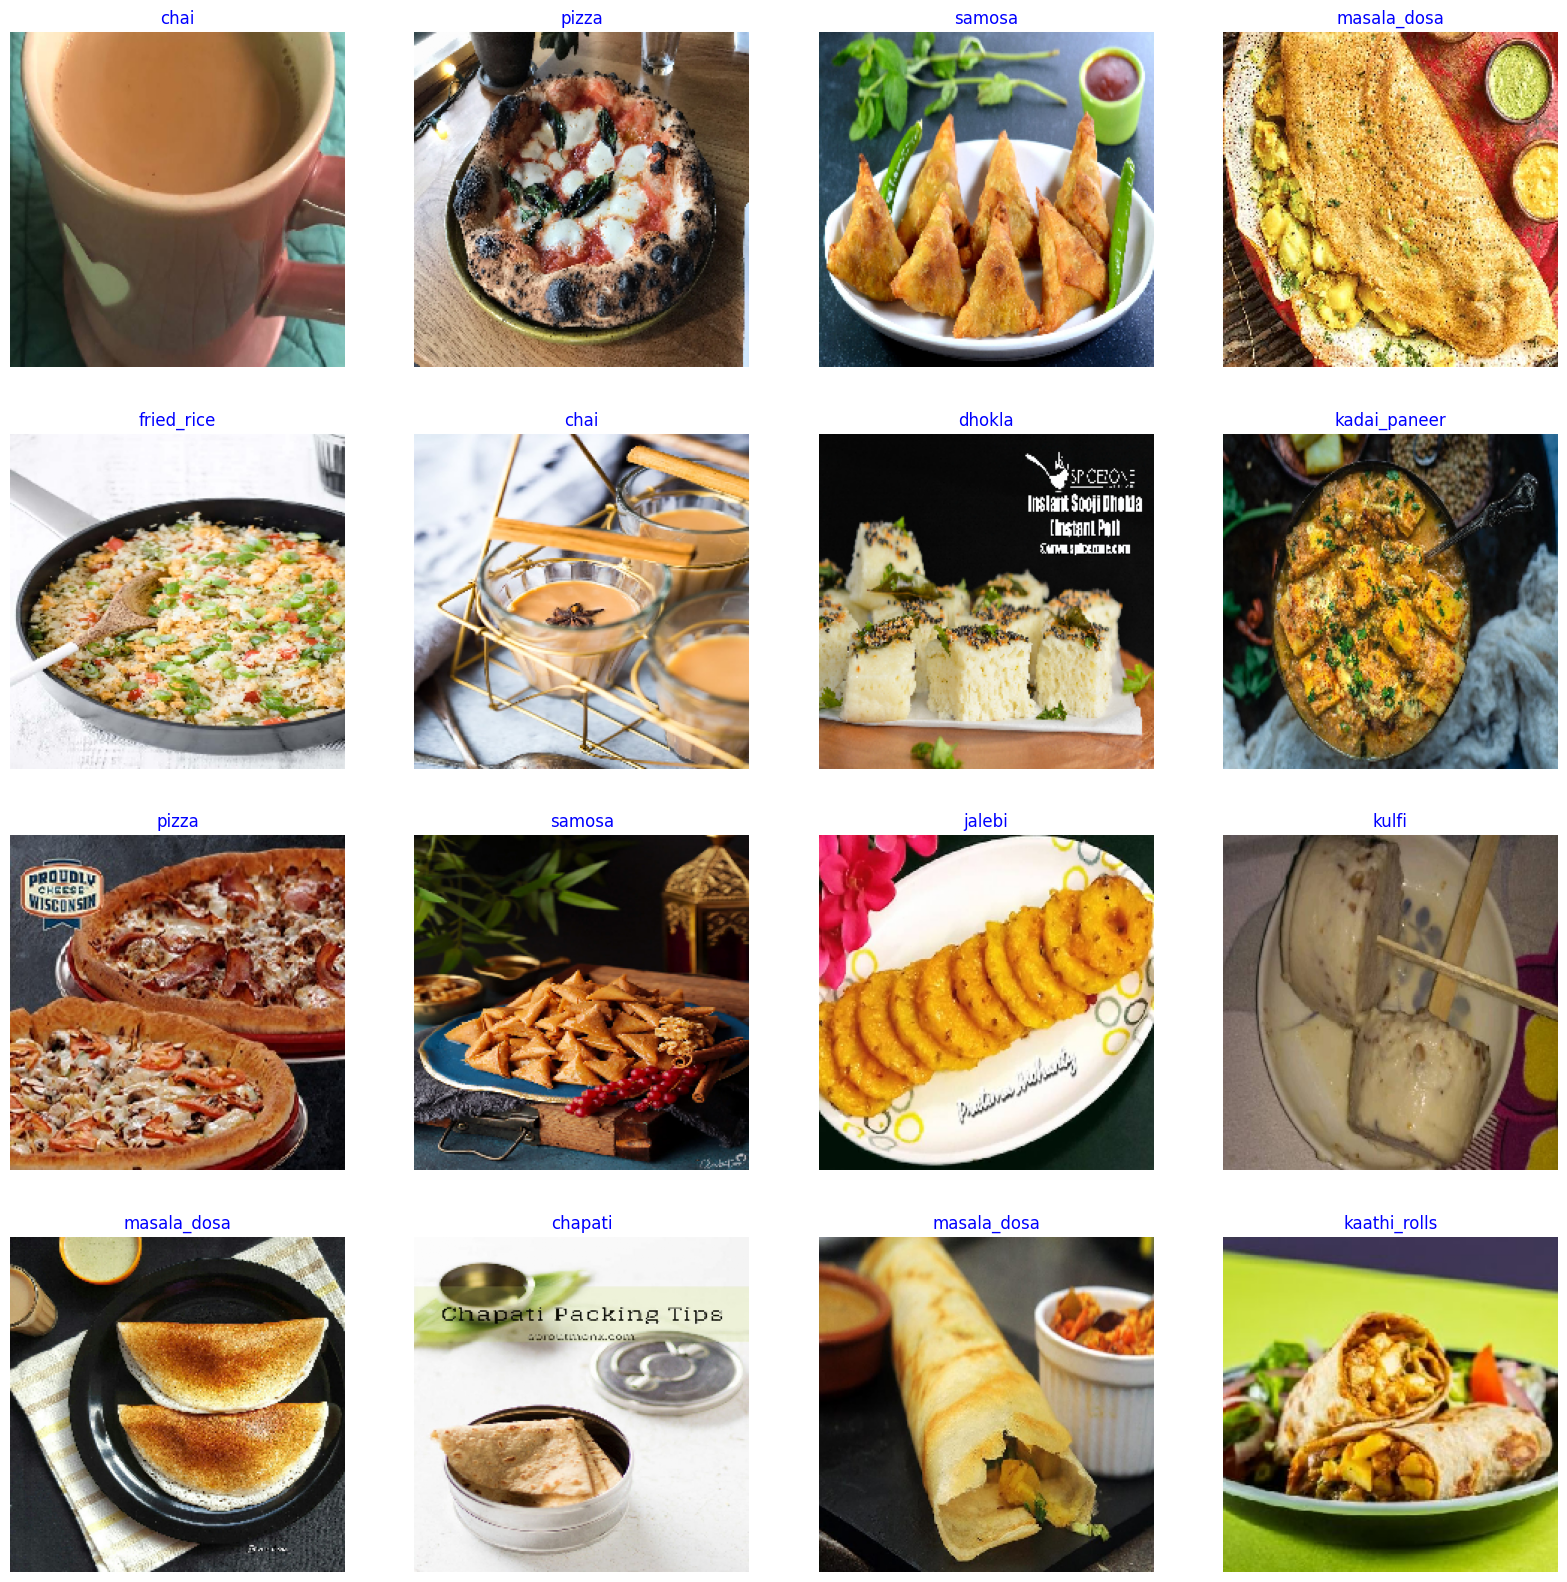

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/food_classification.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
model=loaded_model

In [ ]:
from PIL import Image
import io
import ipywidgets as widgets
import tensorflow as tf
import supervision as sv
import cv2
from roboflow import Roboflow
import pandas as pd

# Define variables for predicted class and count
predicted_class = ""
count = 0

# Load the dataset containing food items and their corresponding calorie values
calorie_dataset_path = '/content/drive/MyDrive/calorie.csv'
calorie_df = pd.read_csv(calorie_dataset_path)

# Define cutoffs for various health conditions
cutoffs = {
    'Obesity': 2500,  # CDC recommendation
    'Type 2 Diabetes': 2200,  # American Diabetes Association recommendation
    'Cardiovascular Diseases': 2400,  # American Heart Association recommendation
    'Hypertension': 2400,  # World Health Organization suggestion
    'Cancer': 2400,  # American Cancer Society recommendation
    'Liver Disease': 2400,  # Liver Foundation suggestion
    'Kidney Disease': 2400  # National Kidney Foundation recommendation
}

# Function to estimate calorie content based on the food item and quantity consumed
def estimate_calories(food_item, quantity):
    if food_item.lower() in calorie_df['Food_items'].str.lower().values:
        # Find the corresponding calorie value for the food item
        calorie_per_unit = calorie_df.loc[calorie_df['Food_items'].str.lower() == food_item.lower(), 'calories( 1 quantity )'].values[0]
        total_calories = calorie_per_unit * quantity
        return total_calories
    else:
        return "Calorie information not available for this food item."

def process_uploaded_image(uploaded_image):
    global predicted_class, count

    image_filename = list(uploaded_image.keys())[0]  # Get the filename of the uploaded image
    image_path = f"/content/{image_filename}"  # Assuming the images are uploaded to the /content directory
    print("Uploaded Image Path:", image_path)  # Print the path of the uploaded image

    try:
        image = Image.open(io.BytesIO(uploaded_image[image_filename]))
    except Exception as e:
        print("Error opening image:", e)
        return

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = classes
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_labels[tf.argmax(score)]
    print(f"Predicted class: {predicted_class}")

    # Object detection and annotation
    try:
        result = model.predict(image_path, confidence=25, overlap=75).json()
    except Exception as e:
        print("Error predicting with model:", e)
        return

    detections = sv.Detections.from_roboflow(result)
    count = sum(1 for prediction in result['predictions'] if prediction['class'].lower() == predicted_class.lower())
    print("Number of food items :", count)

    # Read the image using OpenCV for annotation
    try:
        cv_image = cv2.imread(image_path)
    except Exception as e:
        print("Error reading image with OpenCV:", e)
        return
    annotated_image = bounding_box_annotator.annotate(scene=cv_image, detections=detections)
    # Display annotated image
    sv.plot_image(image=annotated_image, size=(10, 10))
    # Estimate the calorie content
    calorie_estimate = estimate_calories(predicted_class, count)
    print(f"Predicted Food Item: {predicted_class}")
    print(f"Estimated Calorie Content: {calorie_estimate} calories")

    # Check if calorie intake exceeds cutoffs for health conditions
    exceeded_condition = False
    exceeded_conditions = []
    total_calories = calorie_estimate
    for condition, cutoff in cutoffs.items():
        if total_calories > cutoff:
            exceeded_condition = True
            exceeded_conditions.append(condition)

    if exceeded_condition:
        print(f"Warning: Your total calorie intake exceeds the cutoff for {', '.join(exceeded_conditions)}.\n"
              f"Please consider making healthier food choices and reducing your calorie intake "
              f"to lower your risk of {', '.join(exceeded_conditions)}.")
    else:
        print("Congratulations! Your total calorie intake is within safe limits.")

# Use the file upload widget to upload an image
from google.colab import files
uploaded = files.upload()

# Process the uploaded image
for filename in uploaded.keys():
    process_uploaded_image(uploaded)




Saving e2528ea2-b8a9-4a51-a45b-d4a6e8d5a3c8.jpeg to e2528ea2-b8a9-4a51-a45b-d4a6e8d5a3c8.jpeg
Uploaded Image Path: /content/e2528ea2-b8a9-4a51-a45b-d4a6e8d5a3c8.jpeg
1/1 [==============================] - 0s 43ms/step
Predicted class: samosa
Error predicting with model: Model.predict() got an unexpected keyword argument 'confidence'


Saving images (7).jpeg to images (7).jpeg
Uploaded Image Path: /content/images (7).jpeg
1/1 [==============================] - 0s 31ms/step
Predicted class: chai
Number of food items : 2


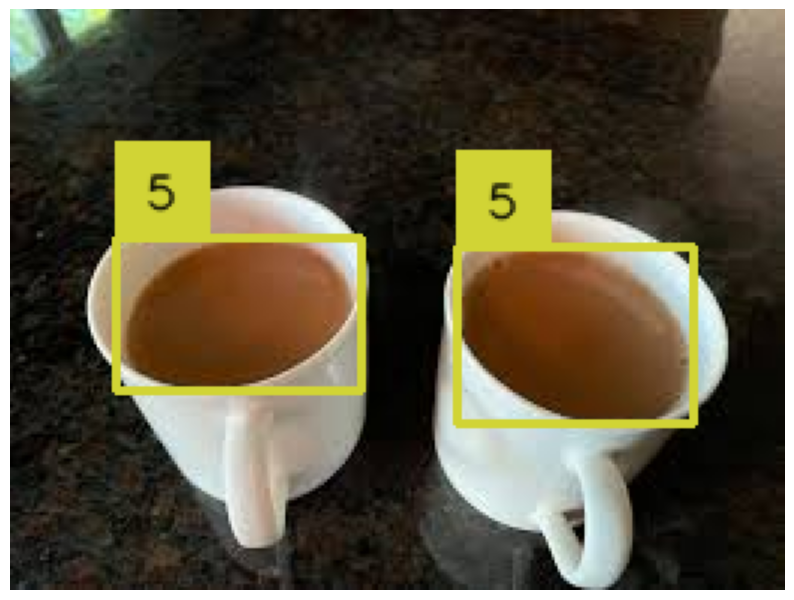

Predicted Food Item: chai
Estimated Calorie Content: 400.0 calories
Congratulations! Your total calorie intake is within safe limits.


In [ ]:
'''from PIL import Image
import io
import tensorflow as tf
import supervision as sv
import cv2
from roboflow import Roboflow
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Define variables for predicted class and count
predicted_class = ""
count = 0

# Load the dataset containing food items and their corresponding calorie values
calorie_dataset_path = '/content/drive/MyDrive/calorie.csv'
calorie_df = pd.read_csv(calorie_dataset_path)

# Define cutoffs for various health conditions
cutoffs = {
    'Obesity': 2500,  # CDC recommendation
    'Type 2 Diabetes': 2200,  # American Diabetes Association recommendation
    'Cardiovascular Diseases': 2400,  # American Heart Association recommendation
    'Hypertension': 2400,  # World Health Organization suggestion
    'Cancer': 2400,  # American Cancer Society recommendation
    'Liver Disease': 2400,  # Liver Foundation suggestion
    'Kidney Disease': 2400  # National Kidney Foundation recommendation
}

# Function to estimate calorie content based on the food item and quantity consumed
def estimate_calories(food_item, quantity):
    if food_item.lower() in calorie_df['Food_items'].str.lower().values:
        # Find the corresponding calorie value for the food item
        calorie_per_unit = calorie_df.loc[calorie_df['Food_items'].str.lower() == food_item.lower(), 'calories( 1 quantity )'].values[0]
        total_calories = calorie_per_unit * quantity
        return total_calories
    else:
        return "Calorie information not available for this food item."

def process_uploaded_image(uploaded_image):
    global predicted_class, count

    image_filename = list(uploaded_image.keys())[0]  # Get the filename of the uploaded image
    image_path = f"/content/{image_filename}"  # Assuming the images are uploaded to the /content directory
    print("Uploaded Image Path:", image_path)  # Print the path of the uploaded image

    try:
        image = Image.open(io.BytesIO(uploaded_image[image_filename]))
    except Exception as e:
        print("Error opening image:", e)
        return

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = classes
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_labels[tf.argmax(score)]
    print(f"Predicted class: {predicted_class}")

    # Object detection and annotation
    try:
        result = model.predict(image_path).json()  # Updated prediction logic
    except Exception as e:
        print("Error predicting with model:", e)
        return

    detections = sv.Detections.from_roboflow(result)
    count = sum(1 for prediction in result['predictions'] if prediction['class'].lower() == predicted_class.lower())
    print("Number of food items :", count)

    # Read the image using OpenCV for annotation
    try:
        cv_image = cv2.imread(image_path)
    except Exception as e:
        print("Error reading image with OpenCV:", e)
        return
    annotated_image = bounding_box_annotator.annotate(scene=cv_image, detections=detections)

    # Display annotated image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Estimate the calorie content
    calorie_estimate = estimate_calories(predicted_class, count)
    print(f"Predicted Food Item: {predicted_class}")
    print(f"Estimated Calorie Content: {calorie_estimate} calories")

    # Check if calorie intake exceeds cutoffs for health conditions
    exceeded_condition = False
    exceeded_conditions = []
    total_calories = calorie_estimate
    for condition, cutoff in cutoffs.items():
        if total_calories > cutoff:
            exceeded_condition = True
            exceeded_conditions.append(condition)

    if exceeded_condition:
        print(f"Warning: Your total calorie intake exceeds the cutoff for {', '.join(exceeded_conditions)}.\n"
              f"Please consider making healthier food choices and reducing your calorie intake "
              f"to lower your risk of {', '.join(exceeded_conditions)}.")
    else:
        print("Congratulations! Your total calorie intake is within safe limits.")

# Use the file upload widget to upload an image
uploaded = files.upload()

# Process the uploaded image
for filename in uploaded.keys():
    process_uploaded_image(uploaded)
'''

FileUpload(value={}, description='Upload')

loading Roboflow workspace...
loading Roboflow project...
Uploaded Image Path: /content/e2528ea2-b8a9-4a51-a45b-d4a6e8d5a3c8.jpeg
1/1 [==============================] - 0s 30ms/step
Predicted class: samosa
Number of food items : 1


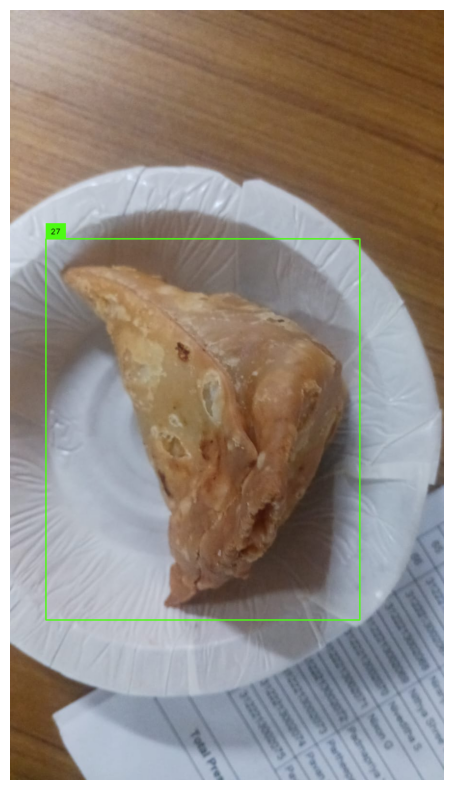

Predicted Food Item: samosa
Estimated Calorie Content: 262.0 calories
Congratulations! Your total calorie intake is within safe limits.


In [ ]:
from PIL import Image
import io
import ipywidgets as widgets
import tensorflow as tf
import supervision as sv
import cv2
from roboflow import Roboflow
import pandas as pd

# Define variables for predicted class and count
predicted_class = ""
count = 0

# Load the dataset containing food items and their corresponding calorie values
calorie_dataset_path = '/content/drive/MyDrive/calorie.csv'
calorie_df = pd.read_csv(calorie_dataset_path)

# Define cutoffs for various health conditions
cutoffs = {
    'Obesity': 2500,  # CDC recommendation
    'Type 2 Diabetes': 2200,  # American Diabetes Association recommendation
    'Cardiovascular Diseases': 2400,  # American Heart Association recommendation
    'Hypertension': 2400,  # World Health Organization suggestion
    'Cancer': 2400,  # American Cancer Society recommendation
    'Liver Disease': 2400,  # Liver Foundation suggestion
    'Kidney Disease': 2400  # National Kidney Foundation recommendation
}

# Create a file upload widget
uploader = widgets.FileUpload()
display(uploader)

# Initialize Roboflow API
rf = Roboflow(api_key="DYmbcIMkAqBqWVO8AE9i")
project = rf.workspace().project("indianfoodnet")
model = project.version(1).model

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

# Function to estimate calorie content based on the food item and quantity consumed
def estimate_calories(food_item, quantity):
    if food_item.lower() in calorie_df['Food_items'].str.lower().values:
        # Find the corresponding calorie value for the food item
        calorie_per_unit = calorie_df.loc[calorie_df['Food_items'].str.lower() == food_item.lower(), 'calories( 1 quantity )'].values[0]
        total_calories = calorie_per_unit * quantity
        return total_calories
    else:
        return "Calorie information not available for this food item."

def process_uploaded_image(change):
    global predicted_class, count

    uploaded_image = uploader.data[-1]
    image_filename = list(uploader.value.keys())[0]  # Get the filename of the uploaded image
    image_path = f"/content/{image_filename}"  # Assuming the images are uploaded to the /content directory
    print("Uploaded Image Path:", image_path)  # Print the path of the uploaded image

    try:
        image = Image.open(io.BytesIO(uploaded_image))
    except Exception as e:
        print("Error opening image:", e)
        return

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = classes
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_labels[tf.argmax(score)]
    print(f"Predicted class: {predicted_class}")

    # Object detection and annotation
    try:
        result = model.predict(image_path, confidence=25, overlap=75).json()
    except Exception as e:
        print("Error predicting with model:", e)
        return

    detections = sv.Detections.from_roboflow(result)
    count = sum(1 for prediction in result['predictions'] if prediction['class'].lower() == predicted_class.lower())
    print("Number of food items :", count)

    # Read the image using OpenCV for annotation
    try:
        cv_image = cv2.imread(image_path)
    except Exception as e:
        print("Error reading image with OpenCV:", e)
        return

    annotated_image = bounding_box_annotator.annotate(scene=cv_image, detections=detections)

    # Display annotated image
    sv.plot_image(image=annotated_image, size=(10, 10))

    # Estimate the calorie content
    calorie_estimate = estimate_calories(predicted_class, count)
    print(f"Predicted Food Item: {predicted_class}")
    print(f"Estimated Calorie Content: {calorie_estimate} calories")

    # Check if calorie intake exceeds cutoffs for health conditions
    exceeded_condition = False
    exceeded_conditions = []
    total_calories = calorie_estimate
    for condition, cutoff in cutoffs.items():
        if total_calories > cutoff:
            exceeded_condition = True
            exceeded_conditions.append(condition)

    if exceeded_condition:
        print(f"Warning: Your total calorie intake exceeds the cutoff for {', '.join(exceeded_conditions)}.\n"
              f"Please consider making healthier food choices and reducing your calorie intake "
              f"to lower your risk of {', '.join(exceeded_conditions)}.")
    else:
        print("Congratulations! Your total calorie intake is within safe limits.")


# Attach the event handler to the upload button
uploader.observe(process_uploaded_image, names='data')
